In [1]:
#!pip install torch
#!pip install transformers
#!pip install scipy
# !pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline as pl

## Step 0. Read in Data and NLTK Basics¶


In [2]:
df = pd.read_csv("E:\PROJECTS\Sentiment_analysis\Reviews.csv")
df = df.head(500)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
495,496,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


### Quick EDA


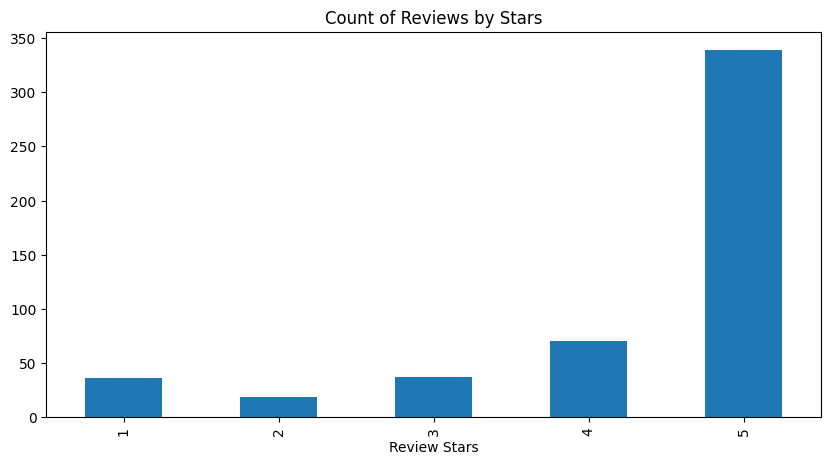

In [3]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [4]:
example = df['Text'][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [5]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [10]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [11]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [12]:
#applying polarity scores to all the reveiws
lst=[]
for i in tqdm(range(len(df))):
    a=sia.polarity_scores(df.Text[i])
    lst.append(a)
res = dict(zip(df.Id,lst))

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
# transforming and combining result into dataset
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.554,0.446,0.9725,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.059,0.799,0.142,0.7833,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,0.025,0.762,0.212,0.9848,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,0.041,0.904,0.055,0.1280,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


## Plot VADER results

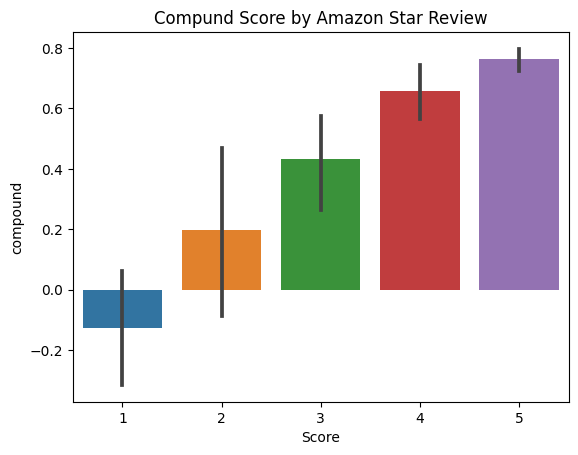

In [14]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


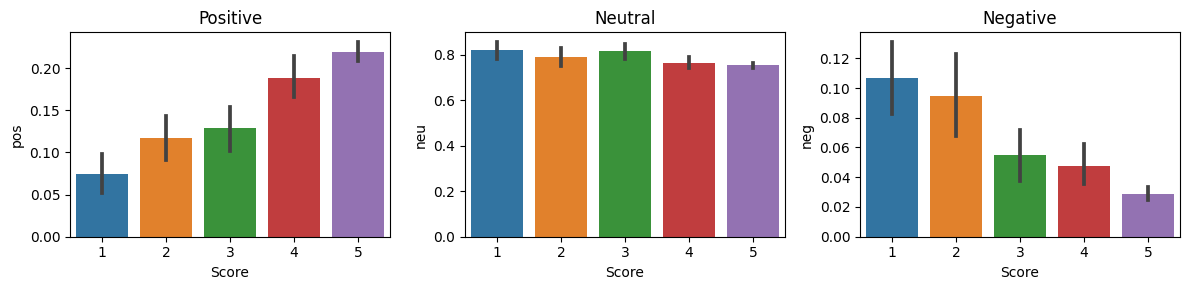

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 2. Roberta pretrained model
RoBERTa is primarily designed to analyze text data and is not explicitly trained to recognize emojis. However, since emojis are a common part of online communication and are often used to convey sentiment, they may be included in the text data that RoBERTa analyzes.

In practice, the ability of RoBERTa to accurately interpret the sentiment of emojis will depend on the specific context in which they are used. For example, a "thumbs up" emoji is generally considered positive, while a "thumbs down" emoji is generally considered negative. However, some emojis may be more ambiguous or open to interpretation, and may require additional context to accurately assess their sentiment.

RoBERTa may be able to learn associations between certain emojis and sentiment through its pre-training on large amounts of text data. However, it is important to keep in mind that RoBERTa, like any language model, is not perfect and may make mistakes or misinterpretations. It is always a good idea to manually check and verify the results of any sentiment analysis tool, particularly when dealing with ambiguous or complex text data.

In [16]:
MODEL= f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [17]:
#run for roberta model
# The output you provided appears to be a dictionary containing two keys, 'input_ids' and 'attention_mask'.

# The 'input_ids' tensor contains a sequence of numerical IDs representing the tokens of a text input. These IDs are based on a pre-trained tokenizer and are used as input to the pre-trained model. In this case, there is only one input sequence represented by a single tensor of shape (1, 30).

# The 'attention_mask' tensor is used to mask padded values in the input sequence. It has the same shape as the 'input_ids' tensor and contains 1s where there are valid tokens and 0s where there are padded tokens.

# Overall, this output is likely a result of encoding a single text input using a pre-trained tokenizer, possibly for use in a machine learning model.
encode_txt=tokenizer(example, return_tensors='pt')
encode_txt

{'input_ids': tensor([[    0,   713,  1021, 38615,    16,    45,   205,     4,  3139, 39589,
           219,     6,  3793,     6,    38,   218,    75,   101,    24,     4,
          3232,  4218,   384,  2923,    16,     5,   169,     7,   213,     4,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

sentence = "The quick brown fox jumps over the lazy dog."
tensor([[ 101, 1996, 4248, 2829, 9641, 2058, 1996, 6866, 3899, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) does each number here specifies each word.
In the example, the input_ids tensor is tensor([[ 101, 1996, 4248, 2829, 9641, 2058, 1996, 6866, 3899, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), and the attention_mask tensor is tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).

Yes, each number in the tensor corresponds to a specific word in the sentence. This tensor is actually a sequence of numerical representations of the words in the sentence, where each number represents the ID of the corresponding word in the vocabulary. The first number, 101, represents the special token [CLS], which is used to indicate the beginning of a sentence. The second number, 1996, corresponds to the ID of the word "we", the third number, 4248, corresponds to the ID of the word "are", and so on, until the end of the sequence, which is padded with zeros to ensure that all sequences have the same length.

but we have 9 words and tensors numbers are around 20?

The numbers in the tensor are actually token IDs, which are generated by the tokenizer. In this case, it seems like the input sentence was tokenized into 10 tokens, including the special tokens [CLS] and [SEP]. The maximum sequence length for the tokenizer might be set to 20 or more, which is why the tensor has that many elements.

You can use the tokenizer.decode() method to convert the token IDs back to words and see which tokens were generated for the input sentence. For example:

yaml
Copy code
input_ids = tensor([[ 101, 1996, 4248, 2829, 9641, 2058, 1996, 6866, 3899, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tokenizer.decode(input_ids[0])
This should output:

css
Copy code
'[CLS] the quick brown fox jumps over the lazy dog [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'
Here, you can see that the tokenizer generated the following tokens for the input sentence: [CLS], the, quick, brown, fox, jumps, over, the, lazy, dog, [SEP], and several [PAD] tokens to pad the sequence length to the maximum length of 20.







In [18]:
output=model(**encode_txt)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict={
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}


In [19]:
#creating function for future use
def polarity_scores_roberta(example):
    encode_txt=tokenizer(example, return_tensors='pt')
    output=model(**encode_txt)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict={
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }
    return scores_dict

In [20]:
lst=[]
for i in tqdm(range(len(df))):
    try:
        vader_res=sia.polarity_scores(df.Text[i])
        #to change name of vader results
        vader_rename={}
        for key, value in vader_res.items():
            vader_rename[f"vader_{key}"]= value

        roberta_res=polarity_scores_roberta(df.Text[i])
        both= {**vader_rename,**roberta_res}
        lst.append(both)
        res = dict(zip(df.Id,lst))
    except RuntimeError:
        print(f"Broke for id {df.Id[i]}")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [21]:
# transforming and combining result into dataset
res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename(columns={'index': 'Id'})
res_df = res_df.merge(df, how='left')
res_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,494,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232,B000G6RYNE,A3N9DN0V2YXAXA,musicalcharge,0,0,5,1203638400,You have to love sea salt and vinegar already,"But if you happen to, like me, there is no bet..."
494,495,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369,B000G6RYNE,A2C5BWOM7329UD,Jason T. Stevens,0,0,5,1203465600,Addictive,These are the best potato chips I've ever tast...
495,496,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...


## step3: combine and compare

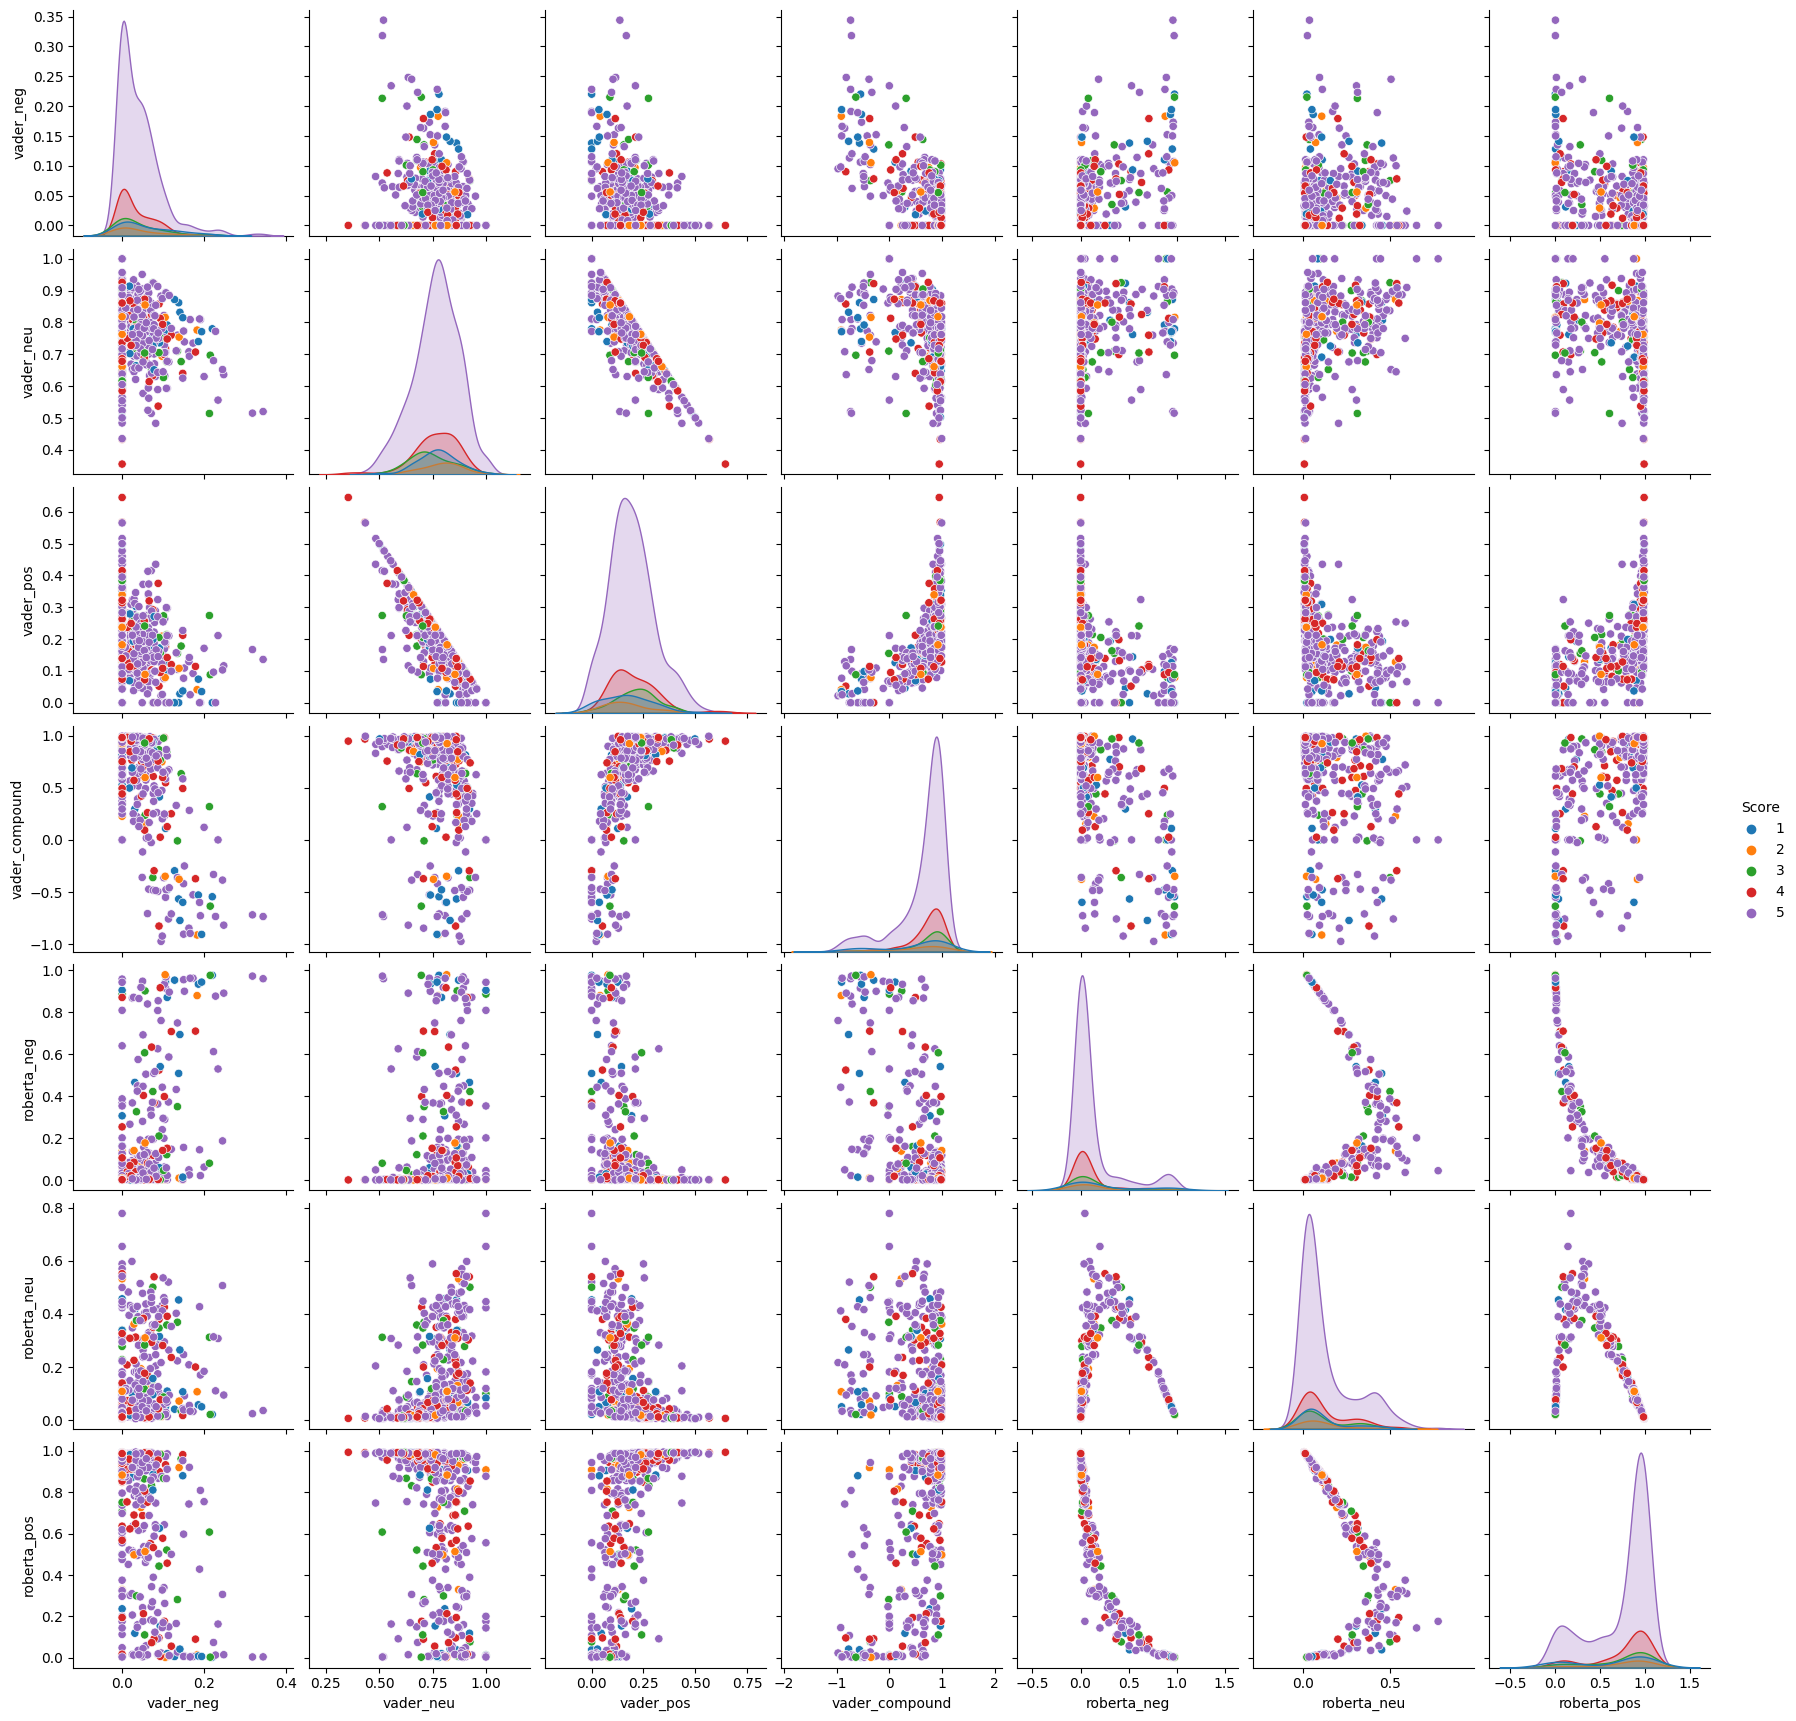

In [22]:
# compare scores between models
sns.pairplot(data=res_df,vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],hue="Score",palette='tab10')
plt.show()

## Step4:  Review Examples

### positive 1-star and negative 5-star reviews
#### Lets look at some examples where the model scoring and review score differ the most.

In [23]:
# postive 1 star

In [24]:
res_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

"These singles sell for $2.50 - $3.36 at the store for 1 box of 24 singles. I'm not sure why Amazon is selling it for $9.99 for a box of 24 singles.  Hazelnut coffee creamer is my favorite, but truly this is not a good buy."

In [25]:
res_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

"I haven't used the ham base. It is loaded with MSG. I did not realize this when I ordered it and can not return it because it is a food item"

In [26]:
#negative 5 star

In [27]:
res_df.query('Score == 5').sort_values('roberta_neg', ascending = False)['Text'].values[0]

'The tomatoes are the star of the classic flavor.  It is clean and really fresh!  Perfect on an avocado chicken sandwich.<br /><br />The spicy flavor is more complex and is the best ketchup I have ever tried.  It is so good I have now used it on foods that would make me seem crazy!'

In [28]:
res_df.query('Score == 5').sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: The Transformers Pipeline
### Extra: The Transformers Pipeline


In [29]:
sent_pipeline= pl("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [30]:
sent_pipeline("the project is completed")

[{'label': 'POSITIVE', 'score': 0.9993607401847839}]

In [31]:
sent_pipeline("after doing all the work i found out there is very less i can offer")

[{'label': 'NEGATIVE', 'score': 0.9992700219154358}]

### END